In [1]:
import os
import cv2
from skimage import io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import argparse
import segmentation_models_v1 as sm
# from segmentation_models_v1 import Unet, Linknet, PSPNet, FPN, DUNet, BiFPN, Nestnet
sm.set_framework('tf.keras')
from regnet_model import Reg_Net

from helper_function import plot_history, generate_folder
# from helper_function import precision, recall, f1_score
# from sklearn.metrics import confusion_matrix

/home/sh38/anaconda3/envs/proGAN_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sh38/anaconda3/envs/proGAN_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sh38/anaconda3/envs/proGAN_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sh38/anaconda3/envs/proGAN_tf/lib/pyt

Segmentation Models: using `keras` framework.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
docker = False

In [4]:
model_dir = './models/regnet'
# model_name = 'regnet-epoch-5000-batch-16-lr-0.0001-dim-256-set-hESC-loss-mse-cross-1'
#model_name = 'regnet-epoch-5000-batch-16-lr-0.0001-dim-256-set-colorectal-loss-mse-cross-1'
#model_name = 'regnet-epoch-5000-batch-16-lr-0.0001-dim-256-set-bone_marrow-loss-mse-cross-1'
model_name = 'regnet-epoch-5000-batch-64-lr-0.0001-dim-128-set-bacterial-loss-mse-cross-1'
#model_names = os.listdir(model_dir)
#model_name = model_names[0]
splits = model_name.split('-')
for v in range(len(splits)):
    if splits[v] == 'set':
        dataset = splits[v+1]
    elif splits[v] == 'cross':
        cross = int(splits[v+1])
print(model_name); print('dataset:{}'.format(dataset)); print('cross:{}'.format(cross))

regnet-epoch-5000-batch-64-lr-0.0001-dim-128-set-bacterial-loss-mse-cross-1
dataset:bacterial
cross:1


In [5]:
if dataset == 'bacterial':
	val_dim = 256; img_dim = 256
elif dataset == 'bone_marrow':
	val_dim = 608; img_dim = 600
elif dataset == 'colorectal':
	val_dim = 512; img_dim = 500
elif dataset == 'hESC':
	val_dim = 512; img_dim = 512

In [6]:
DATA_DIR = '/data/datasets/regnet/{}'.format(dataset) if docker else './datasets/regnet/{}'.format(dataset)
DATA_DIR = DATA_DIR+'/cross-{}'.format(cross)

x_valid_dir = os.path.join(DATA_DIR, 'val', 'images')
y_valid_dir = os.path.join(DATA_DIR, 'val', 'masks')
pred_valid_dir = os.path.join(DATA_DIR, 'val', 'pr_masks'); print(pred_valid_dir)

./datasets/regnet/bacterial/cross-1/val/pr_masks


In [7]:
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bk', 'cell']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None,
            nb_data=None,
            augmentation=None, 
            preprocessing=None,
    ):
        id_list = os.listdir(images_dir)
        if nb_data ==None:
            self.ids = id_list
        else:
            self.ids = id_list[:int(min(nb_data,len(id_list)))]
        #self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        #print(self.images_fps[:4]); print(self.masks_fps[:4])
        print(len(self.images_fps)); print(len(self.masks_fps))
        # convert str names to class values on masks
#         self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = io.imread(self.images_fps[i])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = io.imread(self.masks_fps[i])/255.
#         print(np.unique(mask))
        # extract certain classes from mask (e.g. cars)
#         masks = [(mask == v) for v in self.class_values]
#         print(self.class_values)
#         mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
#         if mask.shape[-1] != 1:
#             background = 1 - mask.sum(axis=-1, keepdims=True)
#             mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, np.expand_dims(mask, axis =-1)
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
#         map_batch = batch[1]
#         map_batch_list = [map_batch]
#         for i in range(4):
#             map_batch_list.append(map_batch[:,::2,::2,:])
#             map_batch = map_batch[:,::2,::2,:]
#         map_batch_list.reverse()
#         map_tuple = ()
#         for i in range(5):
#             map_tuple = map_tuple+(map_batch_list[i],)
        return (batch[0], batch[1])
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [8]:
import albumentations as A
def get_validation_augmentation(dim = 256):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(dim, dim),
        A.RandomCrop(height=dim, width=dim, always_apply=True)
#         A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)
n_classes = 1 
#create model
net_type = 'Reg_Net'
net_func = globals()[net_type]
model = net_func(None, None, color_type = 3)
model_folder = '/data/models/regnet/{}'.format(model_name) if docker else './models/regnet/{}'.format(model_name)
model_file = model_folder+'/best_model.h5'
print(model_file)
model.load_weights(model_file)

./models/regnet/regnet-epoch-5000-batch-64-lr-0.0001-dim-128-set-bacterial-loss-mse-cross-1/best_model.h5


In [9]:
# evaluate model
test_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes = None,
    augmentation=get_validation_augmentation(val_dim),
    preprocessing=None
)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
pr_masks = model.predict(test_dataloader);pr_masks= pr_masks.squeeze()
images = []; gt_masks = []
for i in range(len(test_dataset)):
    image, gt_mask = test_dataset[i]
    images.append(image); gt_masks.append(gt_mask)
images = np.stack(images)
gt_masks = np.stack(gt_masks).squeeze() #gt_maps = gt_masks.squeeze()
print(gt_masks.max())

# crop 
if dataset == 'bone_marrow' or dataset == 'colorectal':
	offset1, offset2 = int((val_dim-img_dim)/2), val_dim-int((val_dim-img_dim)/2)
	gt_masks=gt_masks[:,offset1:offset2,offset1:offset2]
	pr_masks=pr_masks[:,offset1:offset2,offset1:offset2]
	images=images[:,offset1:offset2,offset1:offset2]
	print('output: {}'.format(pr_masks.shape))

40
40
1.0


In [10]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    SMALL_SIZE = 24
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    return ax

In [14]:
print(pr_masks.mean()); print(images.min())

0.27299544
0


2.1716151


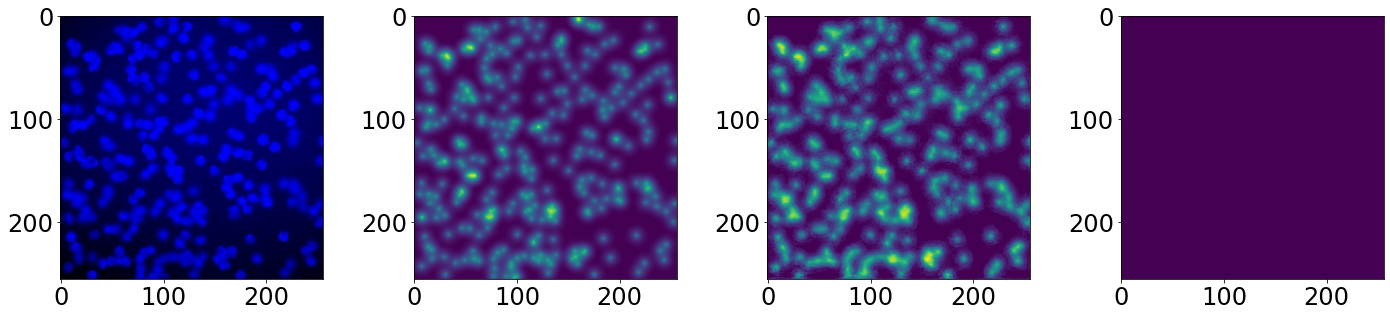

In [16]:
ax = get_ax(rows=1, cols = 4, size =5)
index = 0
ax[0].imshow(images[index]); ax[1].imshow(gt_masks[index]); ax[2].imshow(pr_masks[index])
pr_mask = pr_masks[index]; print(pr_mask.max())
th_mask = pr_mask>0.8
ax[3].imshow(th_mask)

002.png
6835
6835
6835
Detected centroids: 118
255
(600, 600, 3)
2.0024621


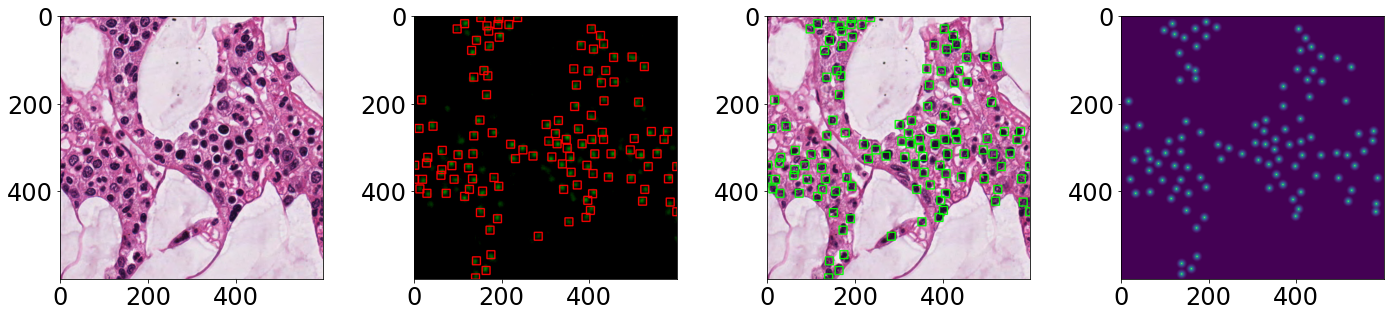

In [47]:
#ax = get_ax(rows=1, cols = 4, size =5)
# Non-maximum suppression
index = 2; pr_mask = pr_masks[index]
print(test_dataset.ids[index])
from nms_python import nms
threshold = 0.8
ys, xs = np.where(pr_mask>threshold)
print(len(xs))
bound_boxes = []
probs = []
hf_box_size = 9
for i in range(len(xs)):
    xi, yi = xs[i], ys[i]; #print(xi,yi)
    x1, x2, y1, y2 = max(0,xi-hf_box_size), min(img_dim,xi+hf_box_size), max(0,yi-hf_box_size), min(img_dim,yi+hf_box_size)
    probs.append(pr_mask[xi,yi])
    bound_boxes.append((x1, y1, x2, y2))
print(len(probs)); print(len(bound_boxes))
boxes = np.array(bound_boxes)
# print(boxes)
det_centroids = nms.non_max_suppression_fast(boxes, probs, overlapThresh=0.3)
print('Detected centroids: {}'.format(len(det_centroids)))
image = images[index]; print(image.max())
orig = image.copy(); print(orig.shape)
for (startX, startY, endX, endY) in det_centroids:
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
print(pr_mask.max())
pr_mask_rgb = np.zeros(image.shape, dtype=np.uint8); pr_mask_rgb[:,:,1] = np.uint8(pr_mask*255./3.)
for (startX, startY, endX, endY) in det_centroids:
    cv2.rectangle(pr_mask_rgb, (startX, startY), (endX, endY), (255, 0, 0), 2)
ax = get_ax(rows=1, cols = 4, size =5)
ax[0].imshow(image); ax[1].imshow(pr_mask_rgb); ax[2].imshow(orig); ax[3].imshow(gt_masks[index])

In [46]:
print(len(test_dataset))
generate_folder(pred_valid_dir)
for index in range(len(test_dataset)):
    npy_file_name = pred_valid_dir+'/{}.npy'.format(test_dataset.ids[index].split('.')[0]); print(npy_file_name)
    np.save(npy_file_name, pr_masks[index])

8
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/000.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/001.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/002.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/003.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/004.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/005.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/006.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/007.npy


In [48]:
pred_masks = []
for index in range(len(test_dataset)):
    npy_file_name = pred_valid_dir+'/{}.npy'.format(test_dataset.ids[index].split('.')[0]); print(npy_file_name)
    pred_masks.append(np.load(npy_file_name))
pred_masks = np.stack(pred_masks)
print(pred_masks.shape); print(pred_masks.max())


./datasets/regnet/bone_marrow/cross-1/val/pr_masks/000.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/001.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/002.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/003.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/004.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/005.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/006.npy
./datasets/regnet/bone_marrow/cross-1/val/pr_masks/007.npy
(8, 600, 600)
2.0024621


Difference:0.0000


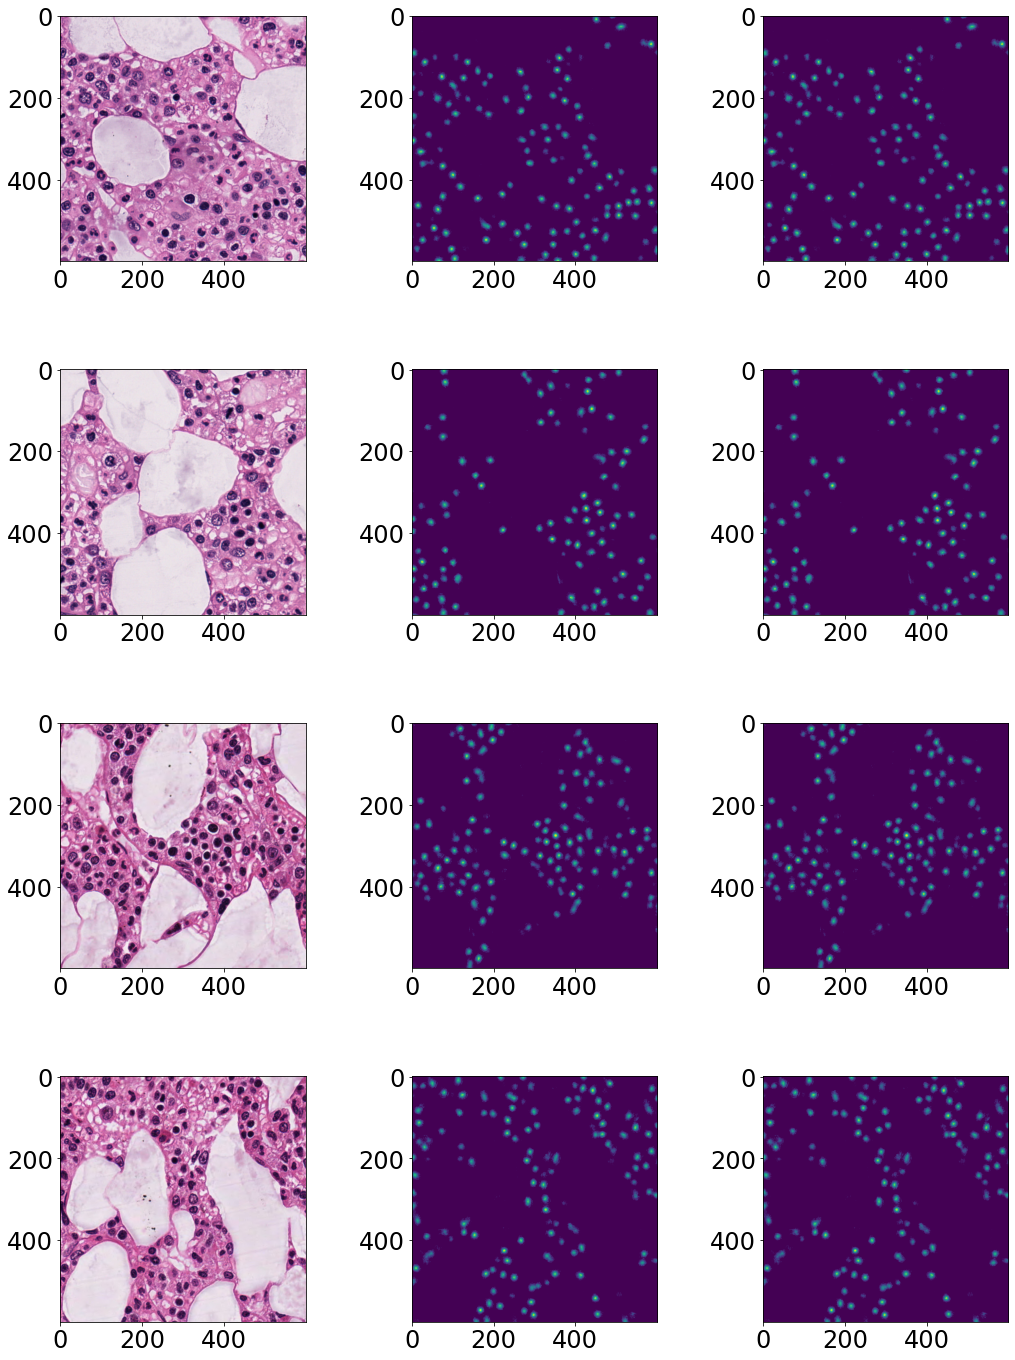

In [50]:
ax = get_ax(rows = 4, cols = 3, size = 5)
for i in range(4):
    ax[i,0].imshow(images[i]); ax[i,1].imshow(pr_masks[i,:]); ax[i,2].imshow(pred_masks[i,:])
print('Difference:{:.4f}'.format(np.abs(pr_masks-pred_masks).mean()))